In [171]:
import scikitplot as skplt
from keras.models import Sequential, Model, Input
from keras.layers import (
    Dense,
    Activation,
    Input,
    SimpleRNN,
    GRU,
    LSTM,
    concatenate,
    Bidirectional,
    TimeDistributed,
    Embedding,
)
import numpy as np
import keras
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    average_precision_score,
    log_loss,
    roc_auc_score,
)

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams.update({"font.size": 18})
plt.rcParams['figure.dpi'] = 200

def prepare_pcap_sequantial_data(
    data, seq_len, forward_predict, standardize, poly, transition
):
    if forward_predict < 1:
        raise ValueError(f"forward_predict should be > 0, {forward_predict} was given!")

    remove = len(data) % seq_len
    preprocess_features = Pipeline(
        steps=[
            (
                "ExtractFeatures",
                FunctionTransformer(
                    lambda x: x[:, :-3] if remove == 0 else x[:-remove, :-3],
                    validate=True,
                ),
            ),
            (
                "Reshaping",
                FunctionTransformer(
                    lambda x: x.reshape((-1, seq_len, x.shape[-1])), validate=True
                ),
            ),
            (
                "Align",
                FunctionTransformer(lambda x: x[:-forward_predict], validate=False),
            ),
        ]
    )

    if standardize:
        preprocess_features.steps.insert(1, ("Scaling", StandardScaler()))

    if poly:
        preprocess_features.steps.insert(
            1, ("PolyFeatures", PolynomialFeatures(2, interaction_only=True))
        )

    preprocess_labels = Pipeline(
        steps=[
            (
                "ExtractLabels",
                FunctionTransformer(
                    lambda x: (x[:, -3:] if remove == 0 else x[:-remove, -3:]),
                    validate=True,
                ),
            ),
            (
                "Reshaping",
                FunctionTransformer(
                    lambda x: x.reshape((-1, seq_len, 3)), validate=True
                ),
            ),
            #             ("Align", FunctionTransformer(lambda x: x[forward_predict:, -1, :].reshape(-1, 4 if transition == 2 else 2), validate=False)),
            (
                "Align",
                FunctionTransformer(
                    lambda x: x[forward_predict:, :, :].reshape(-1, seq_len, 3),
                    validate=False,
                ),
            ),
        ]
    )
    print(len(data) / 10.0)
    x = preprocess_features.fit_transform(data)
    y = preprocess_labels.fit_transform(data)

    return x, y


def split_data(x, y, test_size, random_state):
    #     if x.shape[0] * x.shape[1] > 35_000:
    #         rr = np.random.choice(x.shape[0], int(35_000/x.shape[1]))
    #         x = x[rr]
    #         y = y[rr]
    return train_test_split(x, y, test_size=test_size, random_state=random_state)
all_metrics = {}

In [42]:
data = pd.read_parquet('../../data/no_background/full_pcap_1s_irc.parquet').drop(columns=['label', 'n_abnormal', 'n_background', 'n_normal'])
data.head()

,ent_dst_ip,ent_dst_ip_c,ent_dst_port<1024,ent_src_ip,ent_src_port<1024,ent_src_port>=1024,n_dst_ipclass_b,n_dst_ipclass_c,n_dst_port<1024,n_packets,irc,spam,ddos
0,1.729039,0.0,0.000000,0.395067,0.0,0.000000,45,0,0,52,1,1,0
1,1.814600,0.0,0.598270,0.470615,0.0,0.796312,34,0,7,39,1,1,0
2,1.376031,0.0,0.000000,0.142506,0.0,0.000000,30,0,0,31,1,1,0
3,1.356444,0.0,0.000000,0.198822,0.0,0.693147,47,0,2,49,1,1,0
4,2.250570,0.0,0.995027,0.971464,0.0,1.149060,35,0,9,50,1,1,0


8065.3
Train on 5644 samples, validate on 2420 samples
Epoch 1/10
5644/5644 [==============================] - 38s 7ms/step - loss: 0.4072 - acc: 0.7907 - val_loss: 0.3783 - val_acc: 0.8160
Epoch 2/10
5644/5644 [==============================] - 5s 798us/step - loss: 0.3618 - acc: 0.8288 - val_loss: 0.3419 - val_acc: 0.8487
Epoch 3/10
5644/5644 [==============================] - 5s 799us/step - loss: 0.3426 - acc: 0.8475 - val_loss: 0.3232 - val_acc: 0.8631
Epoch 4/10
5644/5644 [==============================] - 5s 798us/step - loss: 0.3306 - acc: 0.8525 - val_loss: 0.3052 - val_acc: 0.8698
Epoch 5/10
5644/5644 [==============================] - 5s 800us/step - loss: 0.3233 - acc: 0.8587 - val_loss: 0.3030 - val_acc: 0.8738
Epoch 6/10
5644/5644 [==============================] - 4s 796us/step - loss: 0.3165 - acc: 0.8627 - val_loss: 0.2925 - val_acc: 0.8778
Epoch 7/10
5644/5644 [==============================] - 5s 805us/step - loss: 0.3072 - acc: 0.8681 - val_loss: 0.3033 - val_acc: 0

/data/saed/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


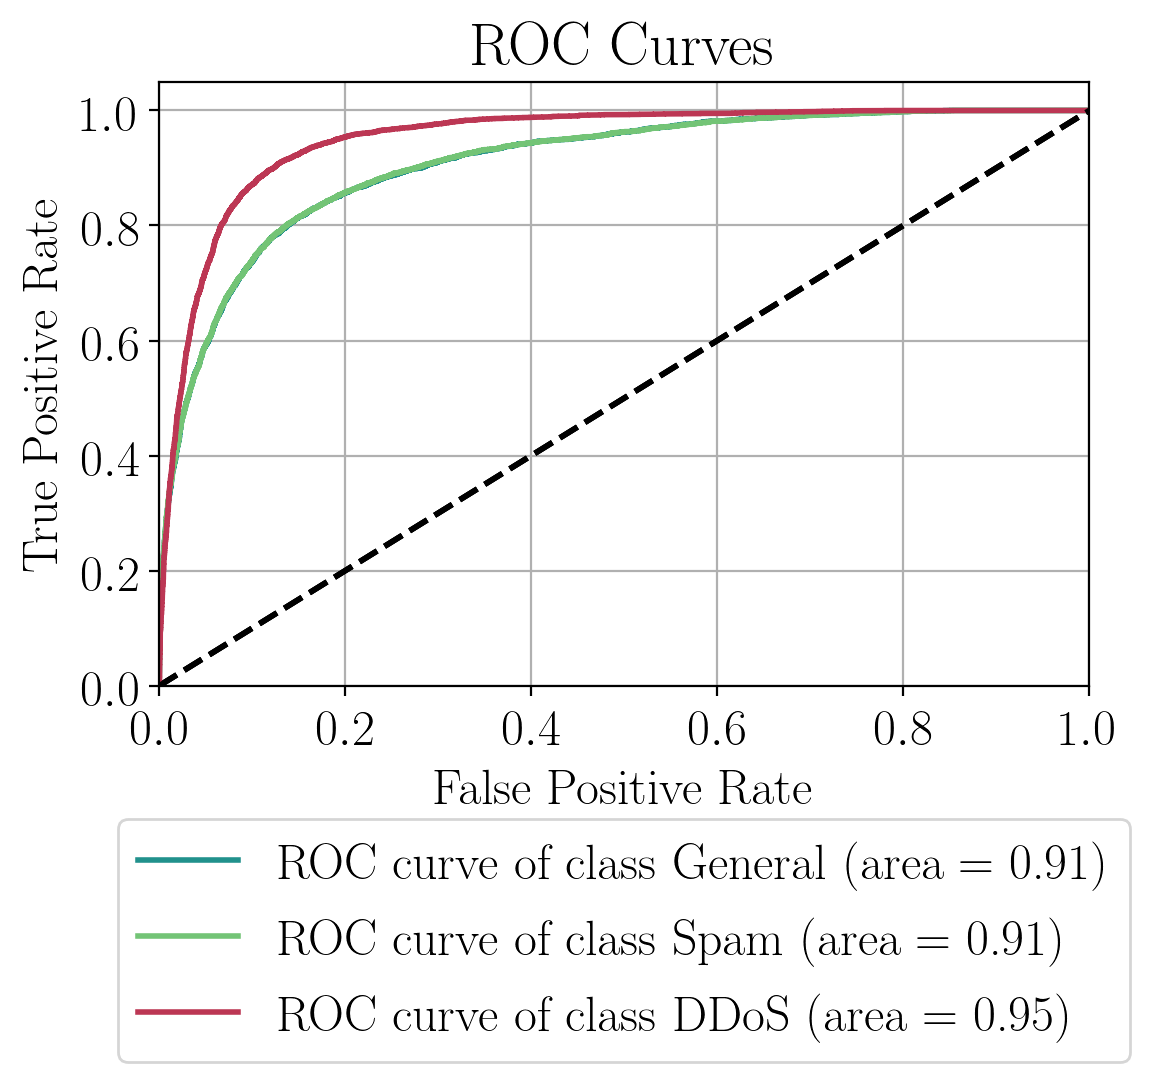

In [210]:
rnn_seq = 10
n_classes = 3
forward_predict = 1
standardize = True
poly = False
transition = 0

for rnn_seq in range(10,11):
    for forward_predict in range(1,2):
        x, y = prepare_pcap_sequantial_data(
                    data, rnn_seq, forward_predict, standardize, poly, transition 
                )

        x_tr, x_te, y_tr, y_te = split_data(x, y, 0.3, 27)

        x_tr = [np.array(x_tr[:,:,i]).reshape(-1,rnn_seq,1) for i in range(10)]
        x_te = [np.array(x_te[:,:,i]).reshape(-1,rnn_seq,1) for i in range(10)]

        inputs = [Input(shape=(rnn_seq,1)) for i in range(10)]
        rnn_units = [Bidirectional(GRU(10, recurrent_dropout=0.3, return_sequences=True))(inputs[i]) for i in range(10)]
        all_units = concatenate(rnn_units)
        out = TimeDistributed(Dense(units=n_classes, activation='sigmoid', name='Output'))(all_units)
        model = Model(inputs, out)
        optimizer = keras.optimizers.Adam(lr=0.01)
        model.compile(optimizer=optimizer,
                  loss=keras.losses.binary_crossentropy,
                  metrics=["accuracy"])

        hist = model.fit(x_tr, y_tr, epochs=10, batch_size=32, validation_data=(x_te, y_te))     
        y_pred = model.predict(x_te)
        metrics = dict()
        f1s = []

        for i in range(3):
            f1s.append([])
            for k in range(100):
                truth = y_te[:, :, i].reshape(-1)
                prediction = (y_pred >= k/100.0)[:,:,i]
                prediction = prediction.reshape(-1,)
                f1s[i].append(f1_score(truth, prediction))
        thresholds = [f1s[0].index(max(f1s[0])) / 100.0, f1s[1].index(max(f1s[1])) / 100.0, f1s[2].index(max(f1s[2])) / 100.0]
        for i in range(3):
            truth = y_te[:, :, i].reshape(-1)
            prediction = (y_pred >= thresholds[i])[:, :, i]
            prediction_prob = y_pred[:, :, i].reshape(-1)

            prediction = prediction.reshape(-1)
            plt.show()
            metrics[f"f1_{i}"] = f1_score(truth, prediction)
            metrics[f"precision_{i}"] = precision_score(truth, prediction)
            metrics[f"recall_{i}"] = recall_score(truth, prediction)
            metrics[f"accuracy_{i}"] = accuracy_score(truth, prediction)
            metrics[f"au-roc_{i}"] = roc_auc_score(truth, prediction_prob)

        all_metrics[f'{rnn_seq}_{forward_predict}'] =  metrics

        from itertools import cycle

        ax = plt.subplot(111)
        ax.grid(True)
        name = ["General", "Spam", "DDoS"]
        colors = cycle(["viridis", "Greens", "inferno"])
        for i in range(3):
            y_prob = np.array(
                [1 - y_pred.reshape(-1, 3)[:, i], y_pred.reshape(-1, 3)[:, i]]
            ).transpose()
            y_truth = [name[i] if k == 1 else "0" for k in y_te.reshape(-1, 3)[:, i]]
            skplt.metrics.plot_roc(
                y_truth,
                y_prob,
                plot_macro=False,
                plot_micro=False,
                classes_to_plot=[name[i]],
                ax=ax,
                cmap=next(colors),
            )
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), fancybox=True, ncol=1)
        plt.savefig(f'../figures/roc_{rnn_seq}_{forward_predict}.png', dpi=200)

In [212]:
from scipy.stats import pearsonr

In [217]:
x_te[0].shape

(2420, 10, 1)

In [275]:
from sklearn.preprocessing import StandardScaler

array([[ 1.8911124 ],
       [ 2.0795047 ],
       [ 2.3222134 ],
       ...,
       [-0.6695827 ],
       [-0.66524965],
       [-0.6550305 ]], dtype=float32)

In [280]:
corr = {}
for i,j in zip(x_te, data.columns[:10]):
    corr[j] = [pearsonr(i.reshape(-1), StandardScaler().fit_transform(y_pred.reshape(-1, 3)[:, 2:]).reshape(-1))[0]]
    
for i,j in zip(x_te, data.columns[:10]):
    corr[j] += [pearsonr(i.reshape(-1), StandardScaler().fit_transform(y_pred.reshape(-1, 3)[:, 1:2]).reshape(-1))[0]]
    
for i,j in zip(x_te, data.columns[:10]):
    corr[j] += [pearsonr(i.reshape(-1), StandardScaler().fit_transform(y_pred.reshape(-1, 3)[:, 0:1]).reshape(-1))[0]]

    
for k in corr.keys():
    corr[k] = np.mean(corr[k])

/data/saed/env/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/data/saed/env/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/data/saed/env/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [281]:
list(sorted(corr.items(), key=lambda kv: (kv[1], kv[0]), reverse=True))

[('ent_src_port<1024', nan),
 ('n_dst_ipclass_c', -0.06079968127700778),
 ('n_dst_ipclass_b', -0.09690185526831764),
 ('n_packets', -0.09983844715169939),
 ('n_dst_port<1024', -0.14248994956216168),
 ('ent_dst_ip', -0.24743218454689112),
 ('ent_dst_port<1024', -0.3808109859763577),
 ('ent_dst_ip_c', -0.4013417746334791),
 ('ent_src_port>=1024', -0.4186803972799939),
 ('ent_src_ip', -0.43417082131412665)]

Text(0, 0.5, 'Feature')

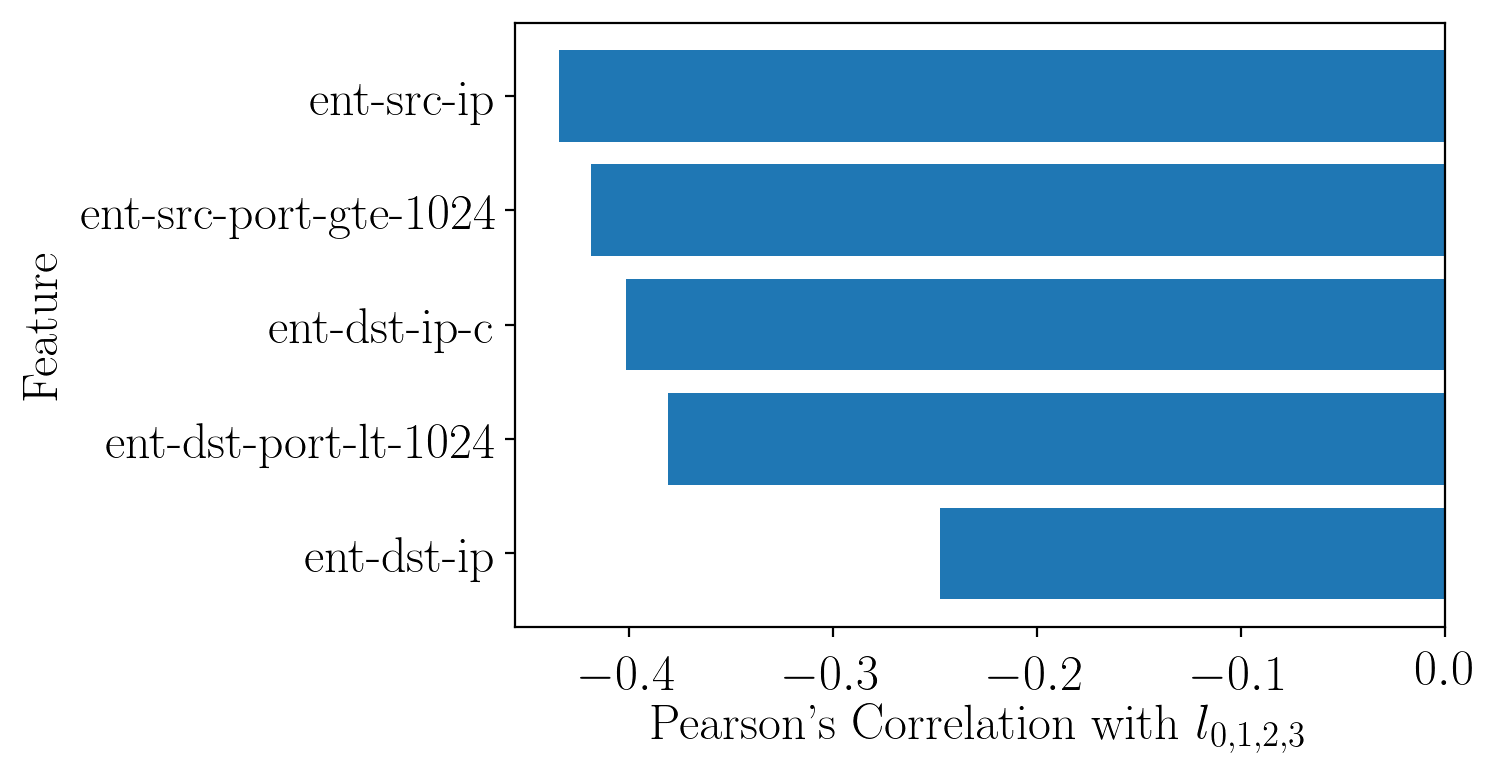

In [291]:
top_features = ['ent_src_ip', 'ent_src_port>=1024', 'ent_dst_ip_c', 'ent_dst_port<1024', 'ent_dst_ip']
top_features.reverse()
plt.barh(range(len(top_features)), [corr[i] for i in top_features])
plt.yticks(range(len(top_features)), [i.replace('_', '-').replace('>=', '-gte-').replace('<', '-lt-') for i in top_features])
plt.xlabel('Pearson\'s Correlation with $l_{0,1,2,3}$')
plt.ylabel('Feature')